In [8]:
import torch, utils
from attention_functions import MultiHeadAttention
from torch import nn
class PositionWiseFFN(nn.Module):
    """
    基于位置的前馈网络(Position Wise Front Feed Network):\n
    基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机, 这就是称前馈网络是基于位置的的原因。\n
    在下面的实现中, 输入X的形状(批量大小, 时间步数或序列长度, 隐单元数或特征维度）\n
    将被一个两层的感知机转换成形状为(批量大小, 时间步数, ffn_num_outputs)的输出张量。
    """
    def __init__(self, ffn_num_inputs, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_inputs, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

# FFN example:
ffn = PositionWiseFFN(4, 4, 8).eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.8624, -0.1493, -1.1623, -0.2767,  0.3303, -0.5270, -0.3214, -0.8324],
        [ 0.8624, -0.1493, -1.1623, -0.2767,  0.3303, -0.5270, -0.3214, -0.8324],
        [ 0.8624, -0.1493, -1.1623, -0.2767,  0.3303, -0.5270, -0.3214, -0.8324]],
       grad_fn=<SelectBackward0>)

In [9]:
layer_norm = nn.LayerNorm(2)
batch_norm = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', layer_norm(X), '\nbatch norm:', batch_norm(X))
class AddNorm(nn.Module):
    """加规范化:使用残差连接和层规范化来实现AddNorm类"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.layer_norm(self.dropout(Y)+ X)
    
# 残差连接要求两个输入的形状相同, 以便加法操作后输出张量的形状相同
add_norm = AddNorm([3, 4], 0.5).eval()
add_norm(torch.ones((2, 3, 4)), torch.zeros((2, 3, 4))).shape

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


torch.Size([2, 3, 4])

In [10]:
class TransformerEncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, query_size, key_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_inputs, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super().__init__(**kwargs)
        self.attention = MultiHeadAttention(query_size, key_size, value_size,
                                            num_hiddens, num_heads, dropout, use_bias)
        self.add_norm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_inputs, ffn_num_hiddens, num_hiddens)
        self.add_norm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.add_norm1(X, self.attention(X, X, X, valid_lens))

SyntaxError: expected ':' (2180656811.py, line 3)

### Transformer架构
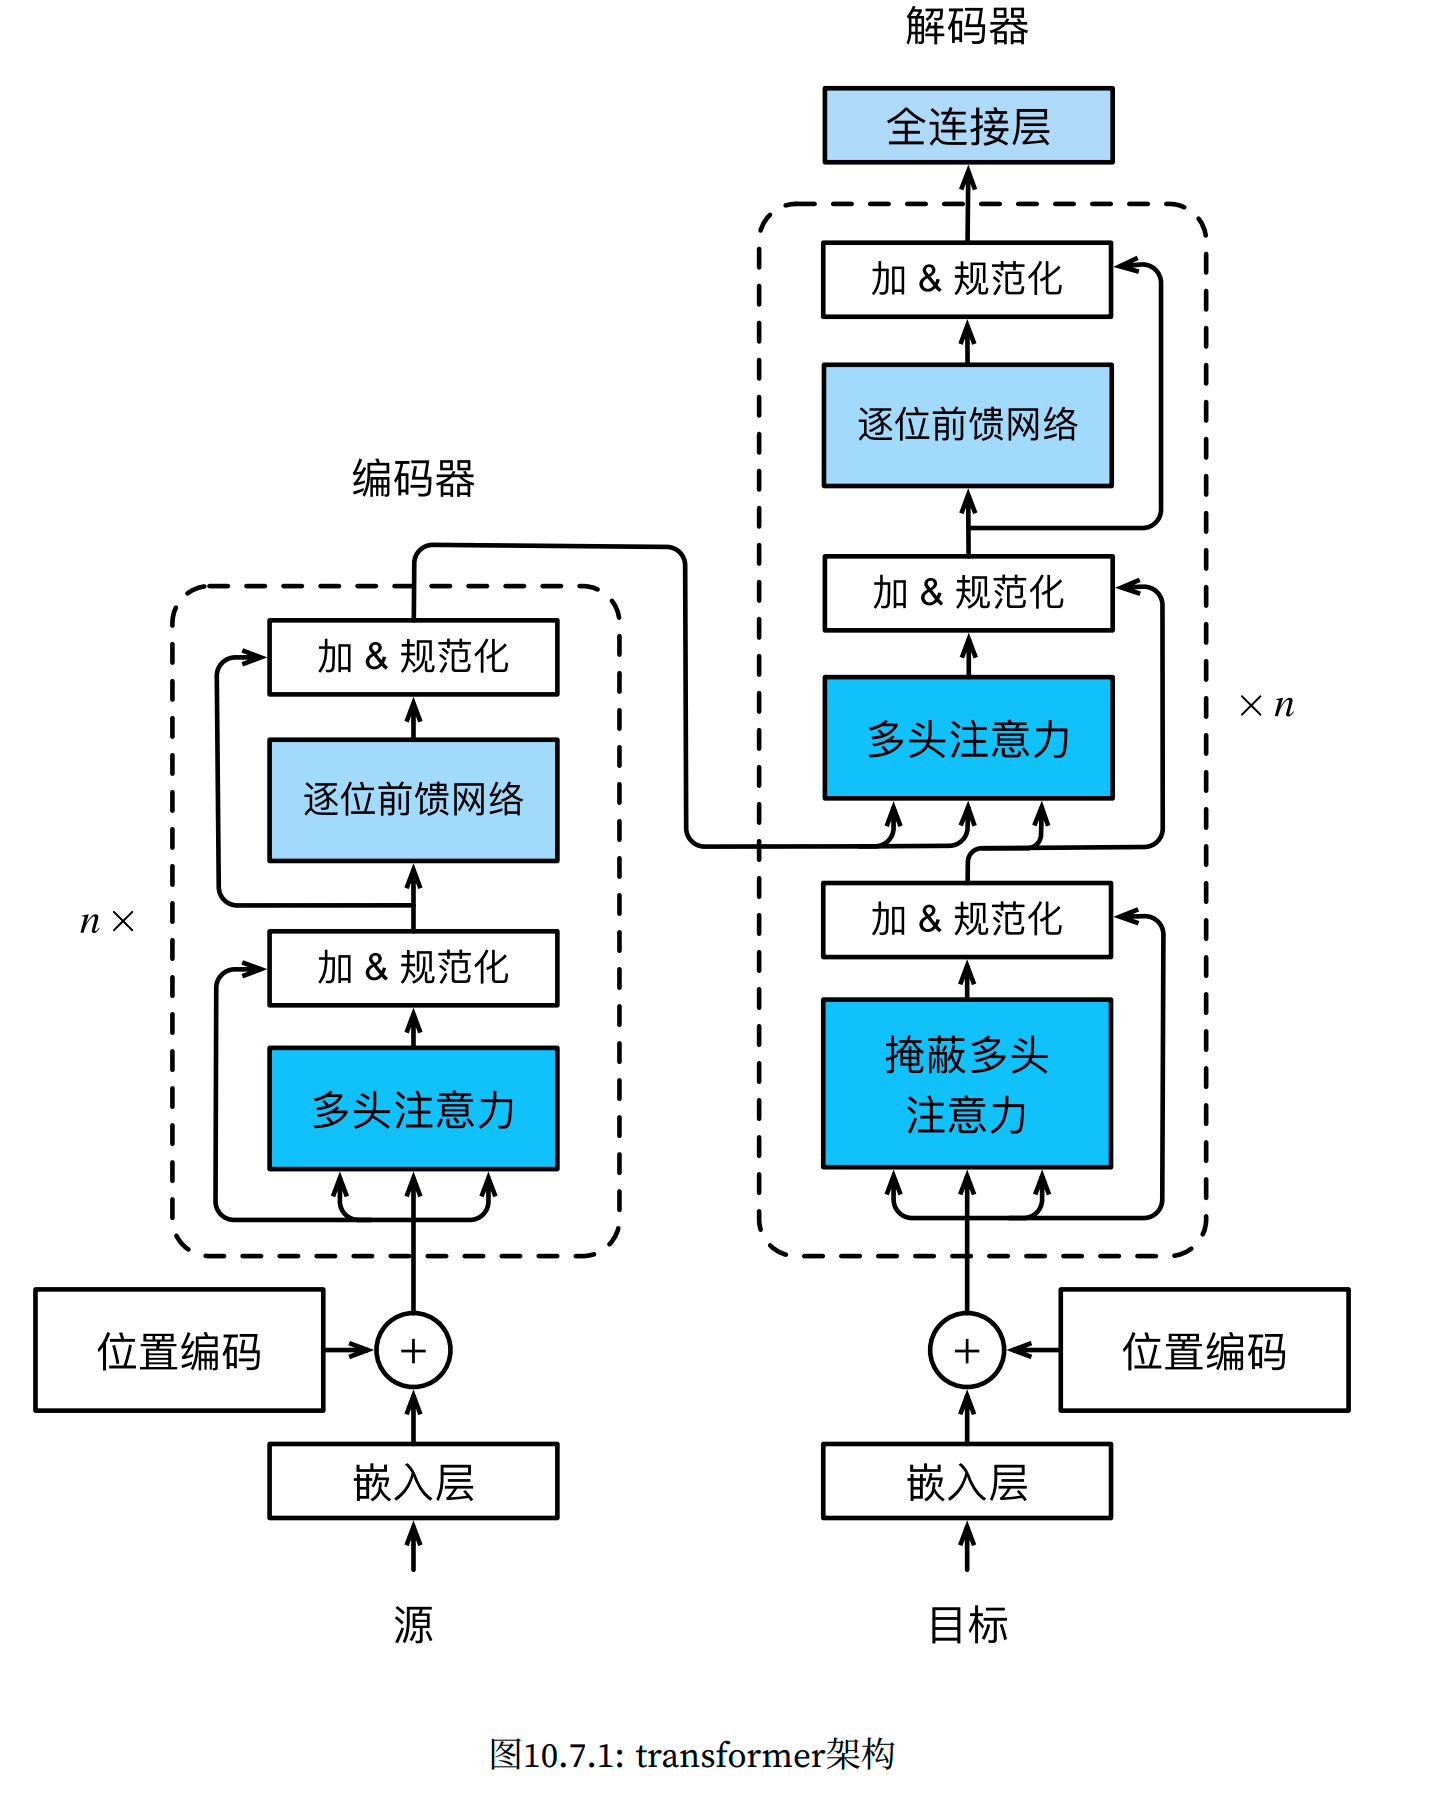